<a href="https://colab.research.google.com/github/FranklinFrostt/PortfolioProjects/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Upload dataset
from google.colab import drive
drive.mount('/content/drive')

# After mounting your Drive, you'll load from the Drive path
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Information:")
print(df.info())

print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check the distribution of fraudulent vs non-fraudulent transactions
print("\nClass distribution:")
print(df['Class'].value_counts())
print(f"Percentage of fraud transactions: {df['Class'].mean()*100:.4f}%")

Dataset shape: (284807, 31)

First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.13745

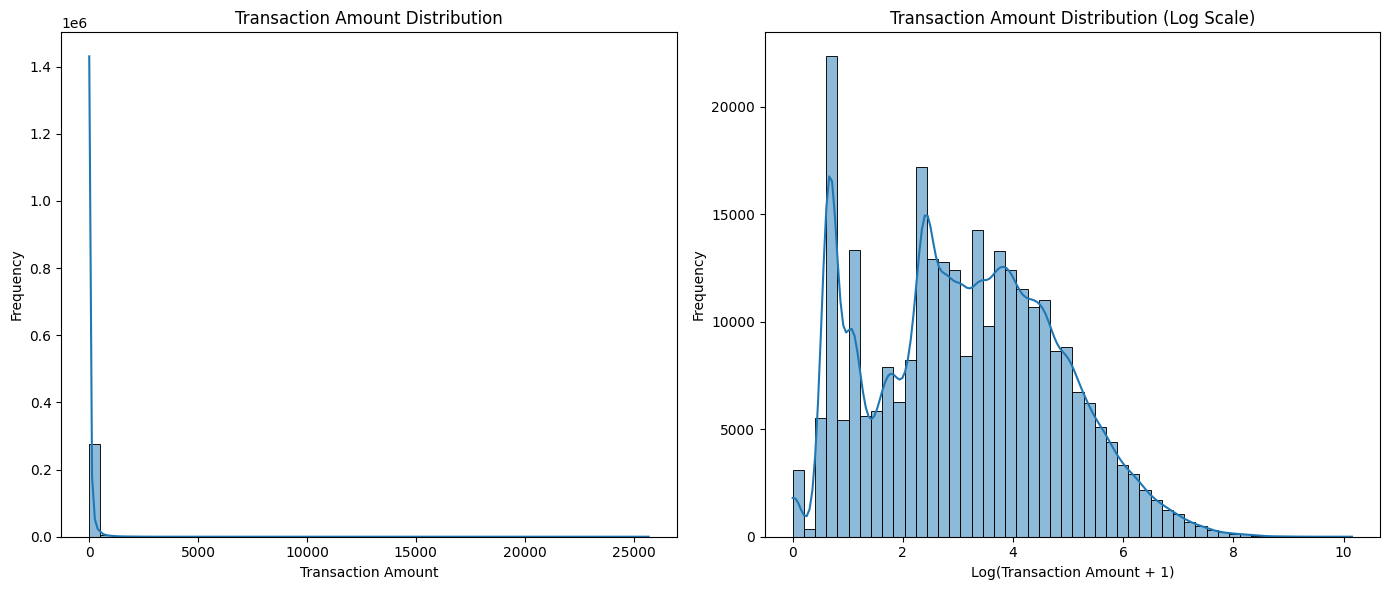

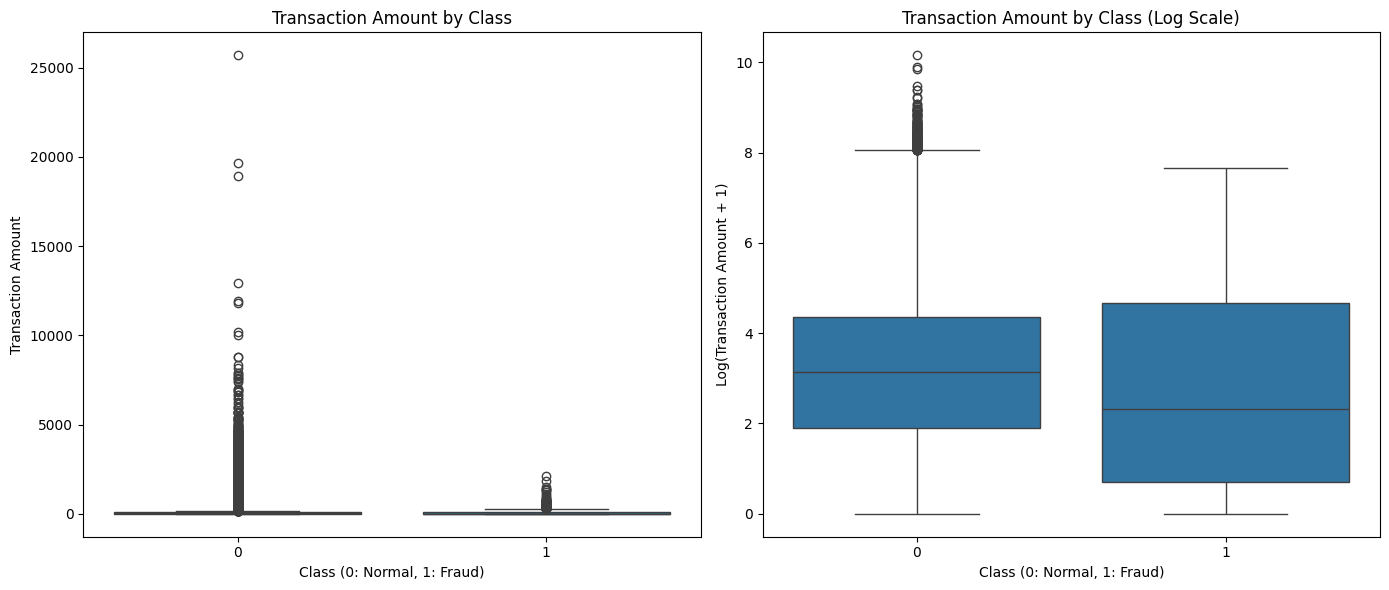

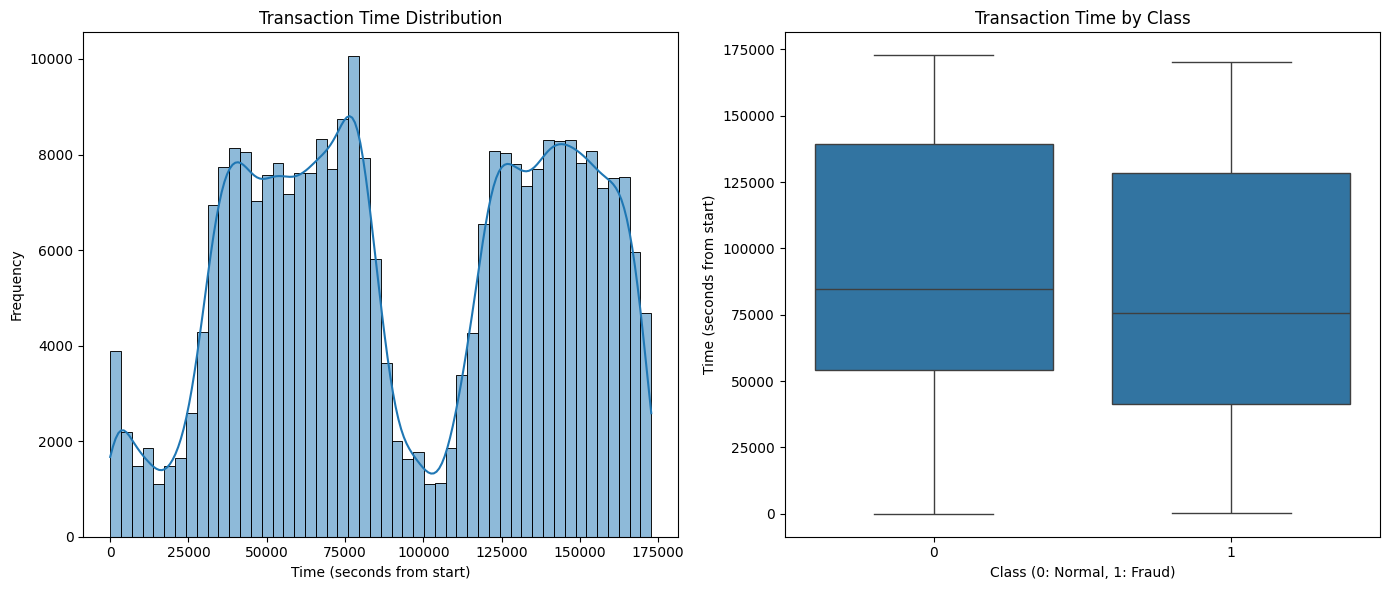

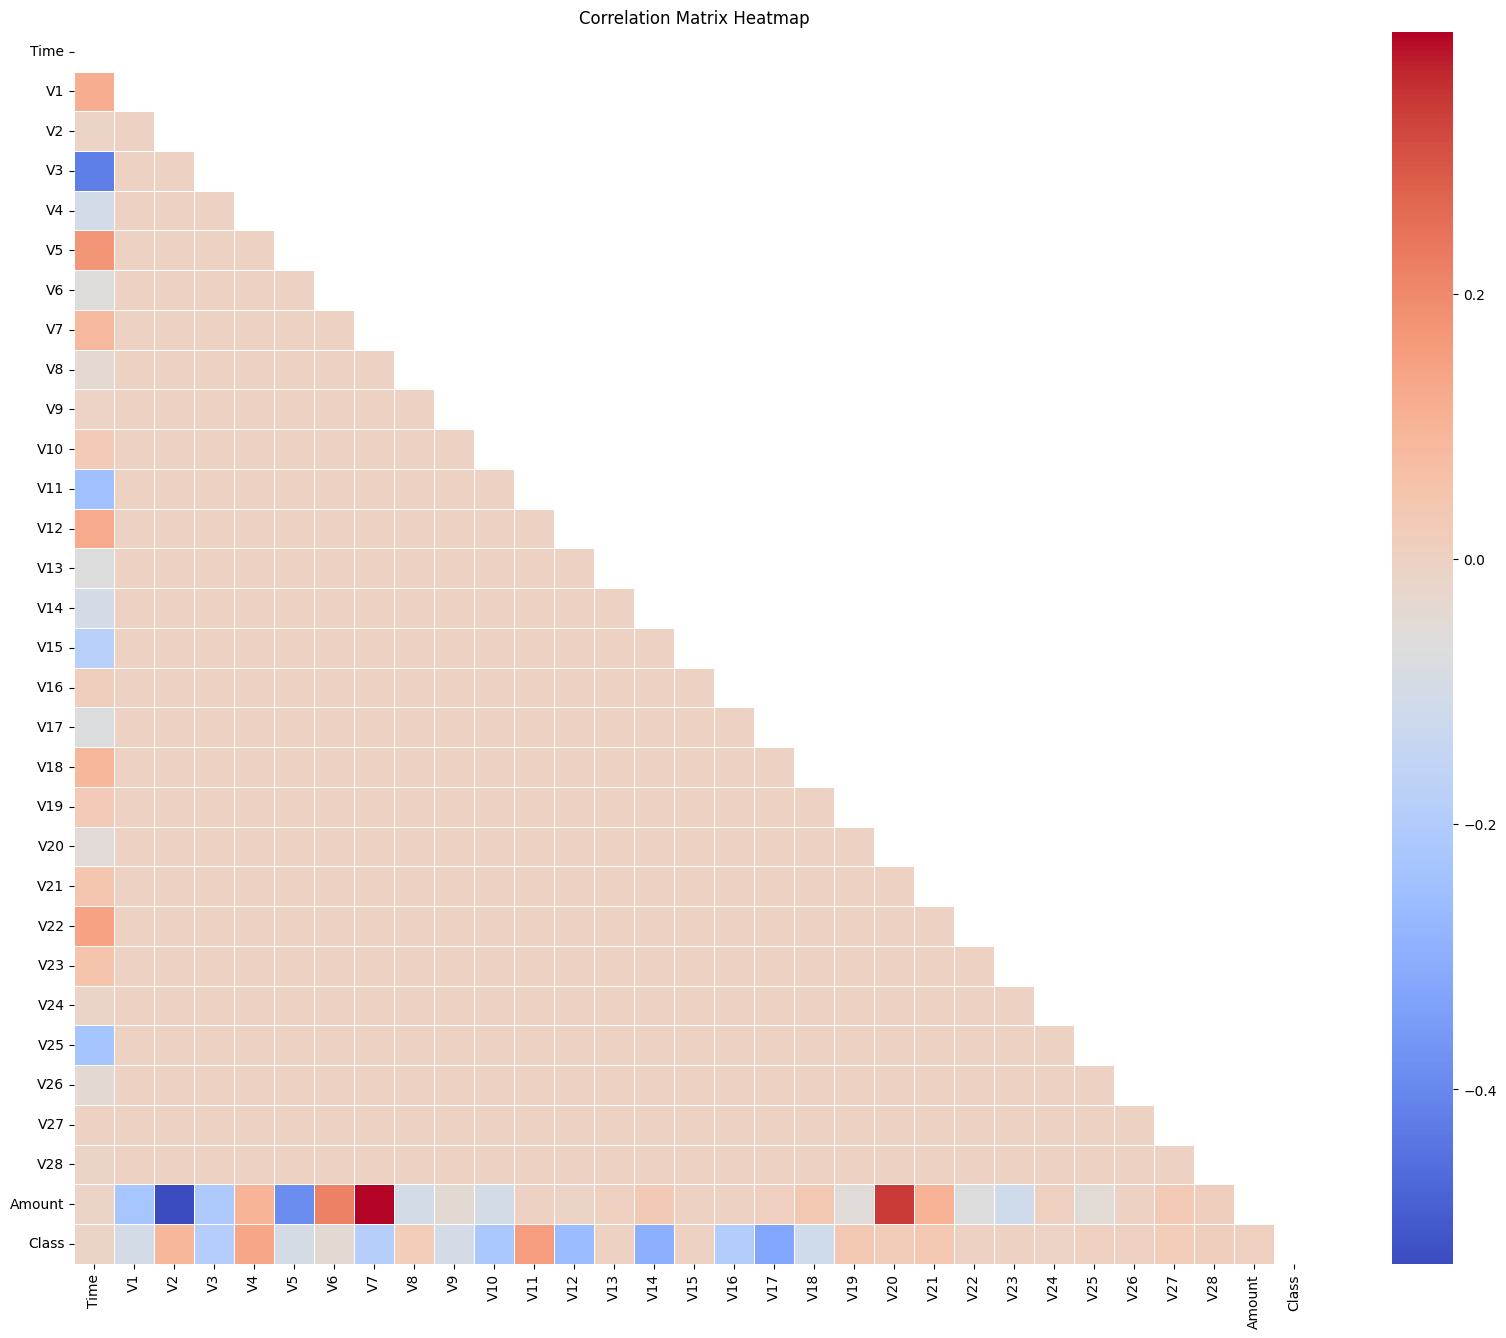

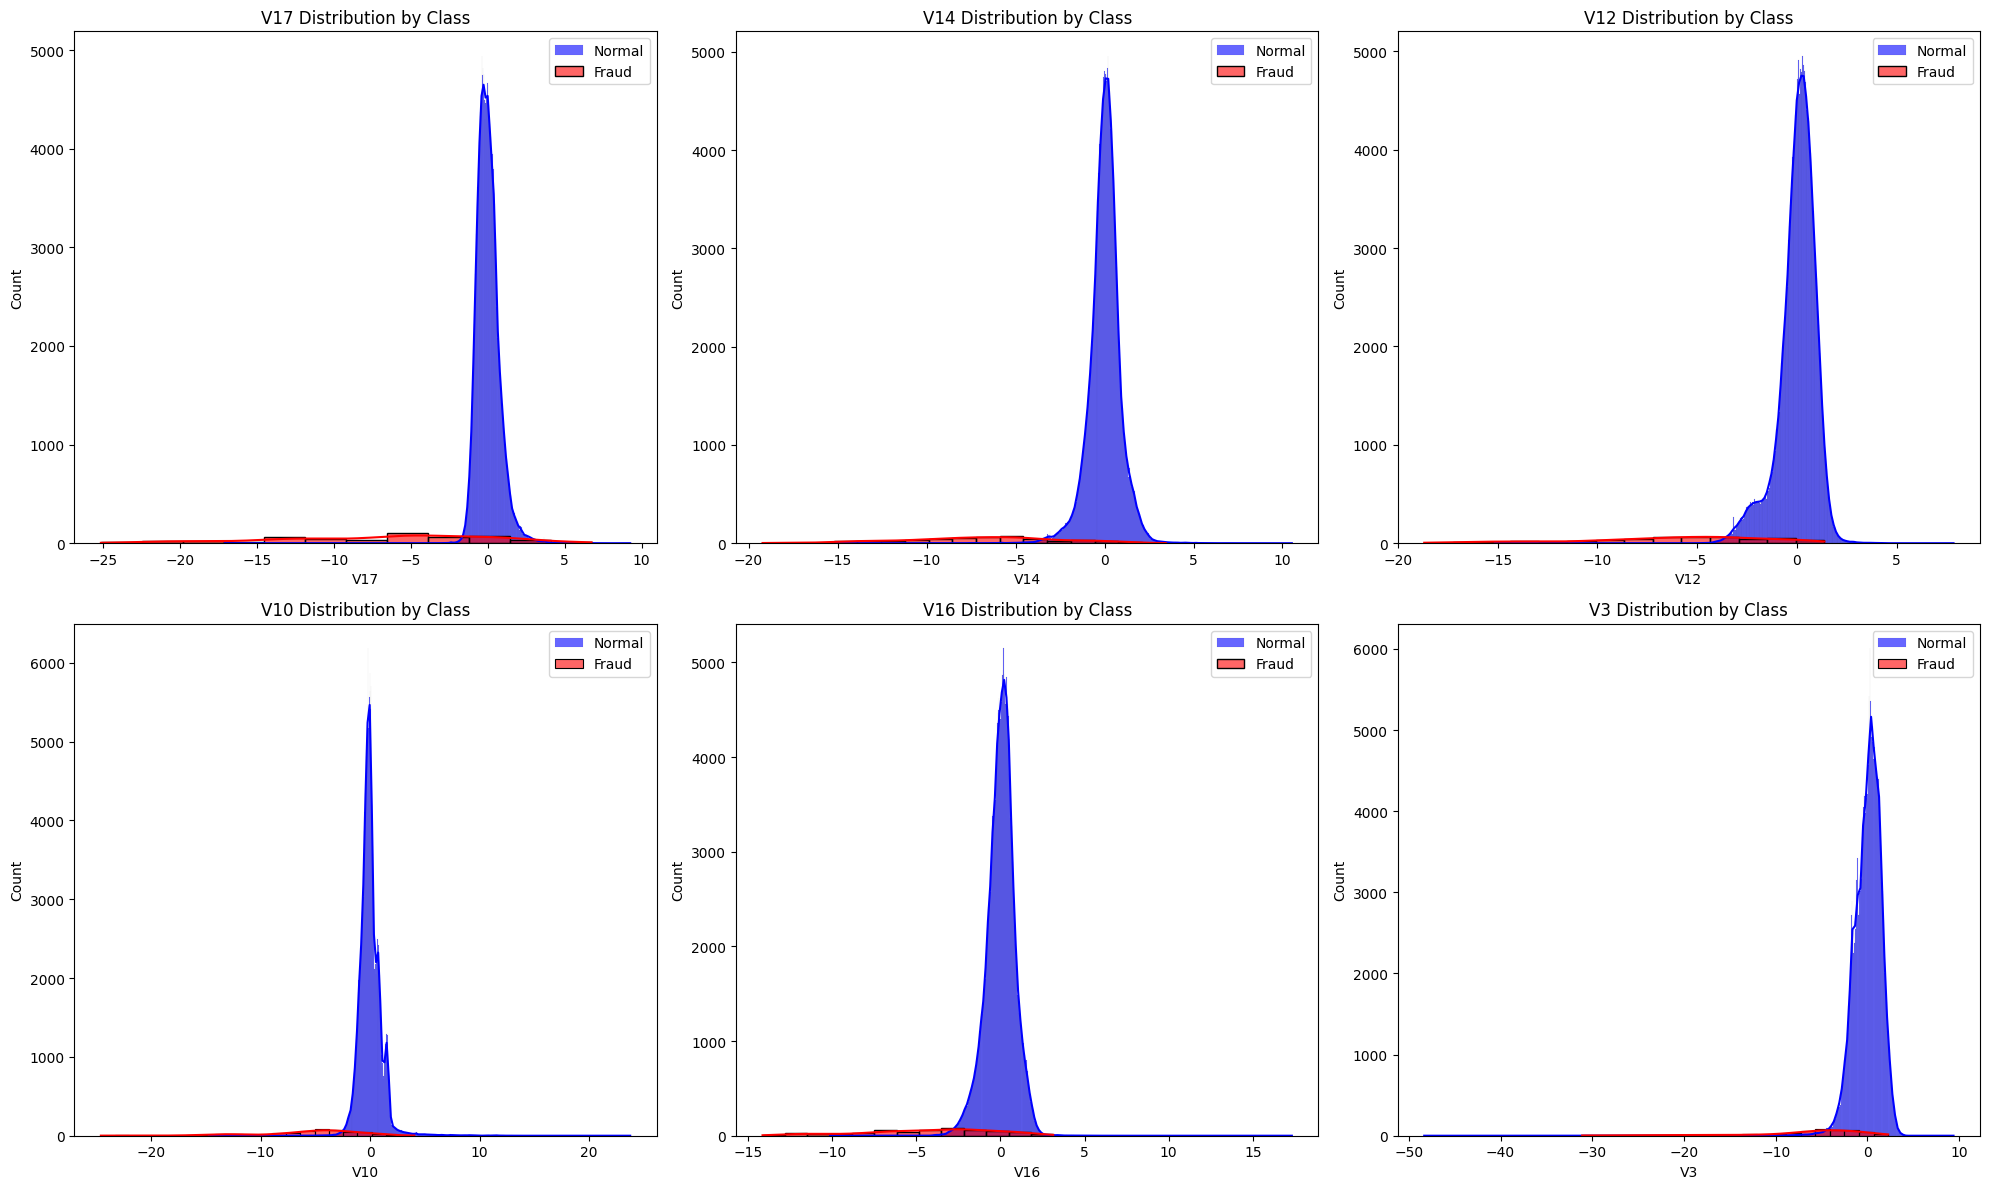

In [9]:
# Section 3: Exploratory Data Analysis
# 3.1 Distribution of transaction amounts for fraudulent vs. non-fraudulent transactions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title('Transaction Amount Distribution')
sns.histplot(df['Amount'], bins=50, kde=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.title('Transaction Amount Distribution (Log Scale)')
sns.histplot(np.log1p(df['Amount']), bins=50, kde=True)
plt.xlabel('Log(Transaction Amount + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 3.2 Compare transaction amounts for fraudulent vs. non-fraudulent transactions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title('Transaction Amount by Class')
sns.boxplot(x='Class', y='Amount', data=df)
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Transaction Amount')

plt.subplot(1, 2, 2)
plt.title('Transaction Amount by Class (Log Scale)')
sns.boxplot(x='Class', y=np.log1p(df['Amount']), data=df)
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Log(Transaction Amount + 1)')

plt.tight_layout()
plt.show()

# 3.3 Examine Time feature
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title('Transaction Time Distribution')
sns.histplot(df['Time'], bins=50, kde=True)
plt.xlabel('Time (seconds from start)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.title('Transaction Time by Class')
sns.boxplot(x='Class', y='Time', data=df)
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Time (seconds from start)')

plt.tight_layout()
plt.show()

# 3.4 Explore correlations with a heatmap
plt.figure(figsize=(20, 16))
correlation_matrix = df.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# 3.5 Examine feature distributions for fraudulent vs non-fraudulent transactions
# Select a few interesting features based on correlation with Class
high_corr_features = correlation_matrix['Class'].sort_values(key=abs, ascending=False)[1:7].index.tolist()

plt.figure(figsize=(20, 12))
for i, feature in enumerate(high_corr_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[df['Class']==0][feature], color='blue', label='Normal', alpha=0.6, kde=True)
    sns.histplot(df[df['Class']==1][feature], color='red', label='Fraud', alpha=0.6, kde=True)
    plt.title(f'{feature} Distribution by Class')
    plt.xlabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# Section 4: Data Preprocessing
# 4.1 Scale the features
# Time and Amount need scaling, V1-V28 are already scaled with PCA

scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop original Time and Amount columns
X = df.drop(['Time', 'Amount', 'Class'], axis=1)
y = df['Class']

print("Shape of preprocessed features:", X.shape)
print("Number of fraudulent transactions:", np.sum(y == 1))
print("Number of normal transactions:", np.sum(y == 0))

# 4.2 Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("Fraud transactions in training set:", np.sum(y_train == 1))
print("Fraud transactions in testing set:", np.sum(y_test == 1))


Shape of preprocessed features: (284807, 30)
Number of fraudulent transactions: 492
Number of normal transactions: 284315
Training set shape: (227845, 30) (227845,)
Testing set shape: (56962, 30) (56962,)
Fraud transactions in training set: 394
Fraud transactions in testing set: 98


Logistic Regression Results:
Training time: 0.92 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



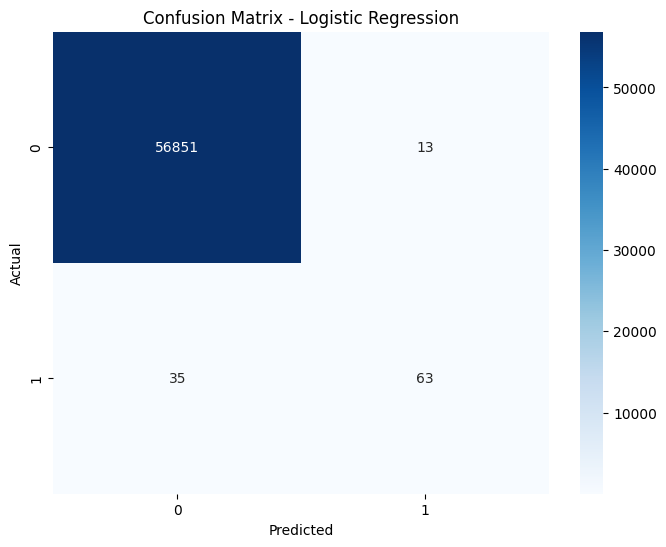

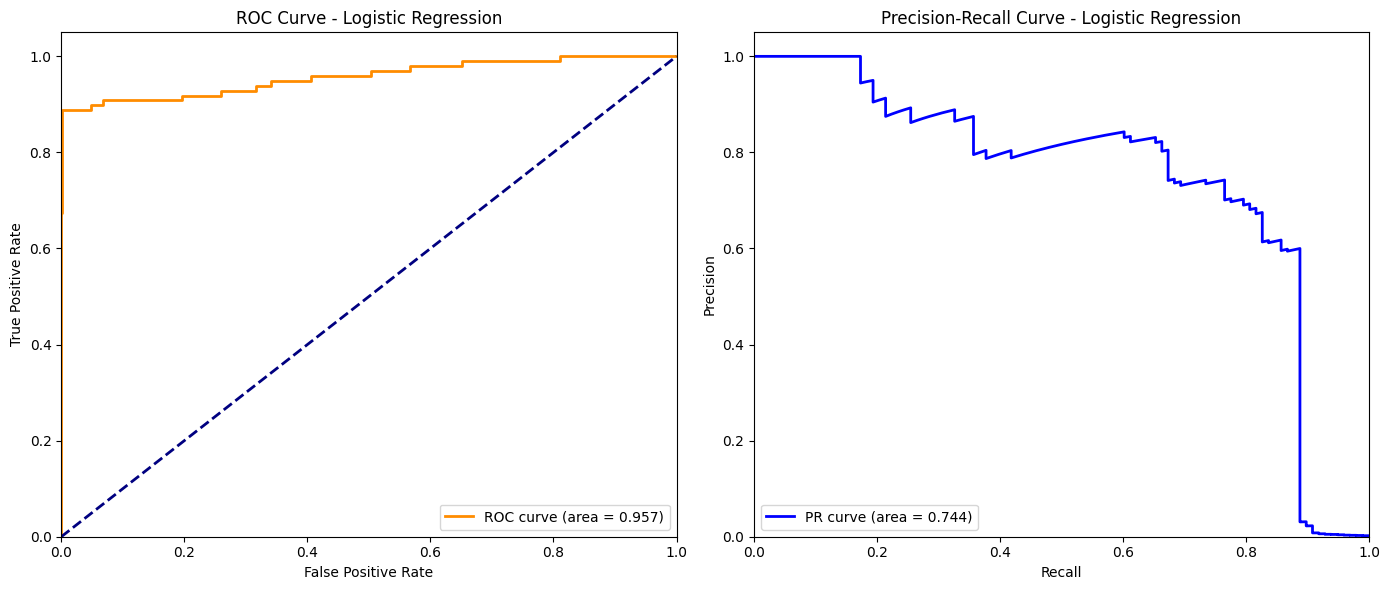

Random Forest Results:
Training time: 265.37 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



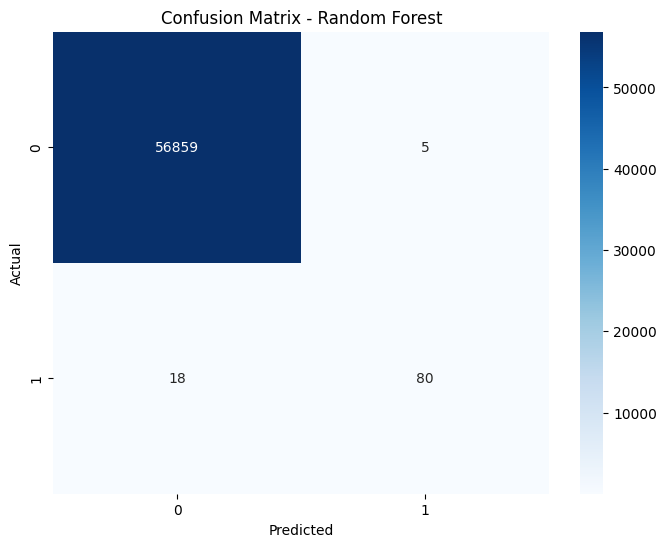

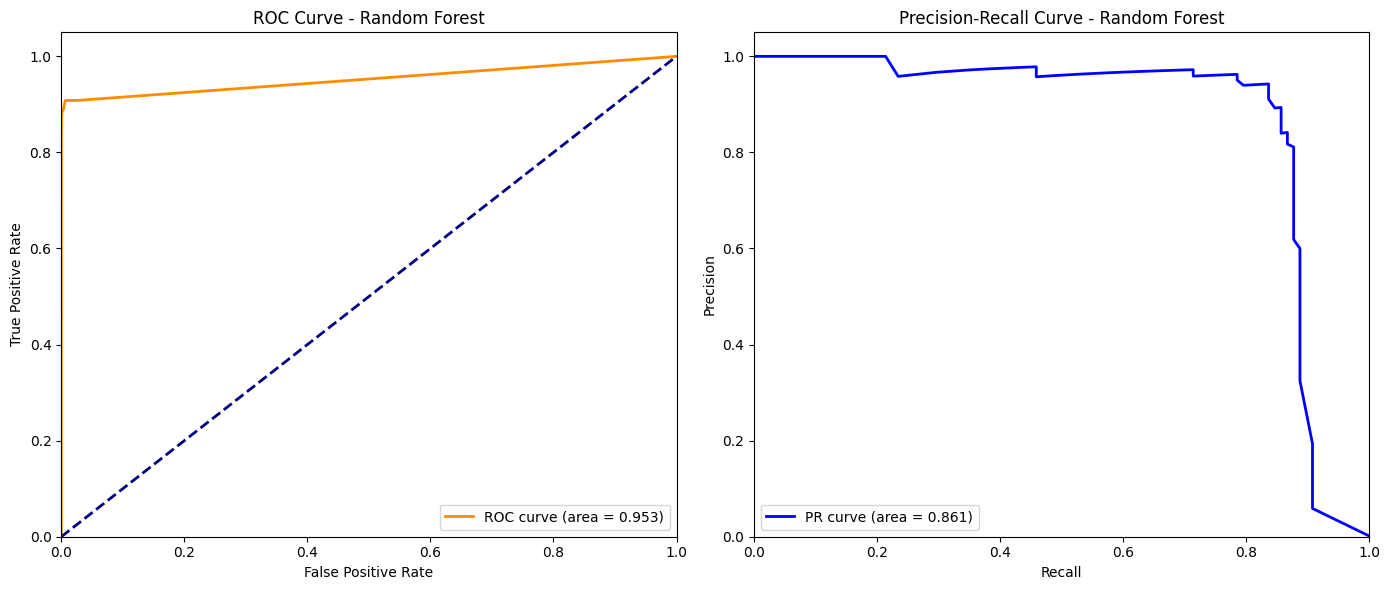

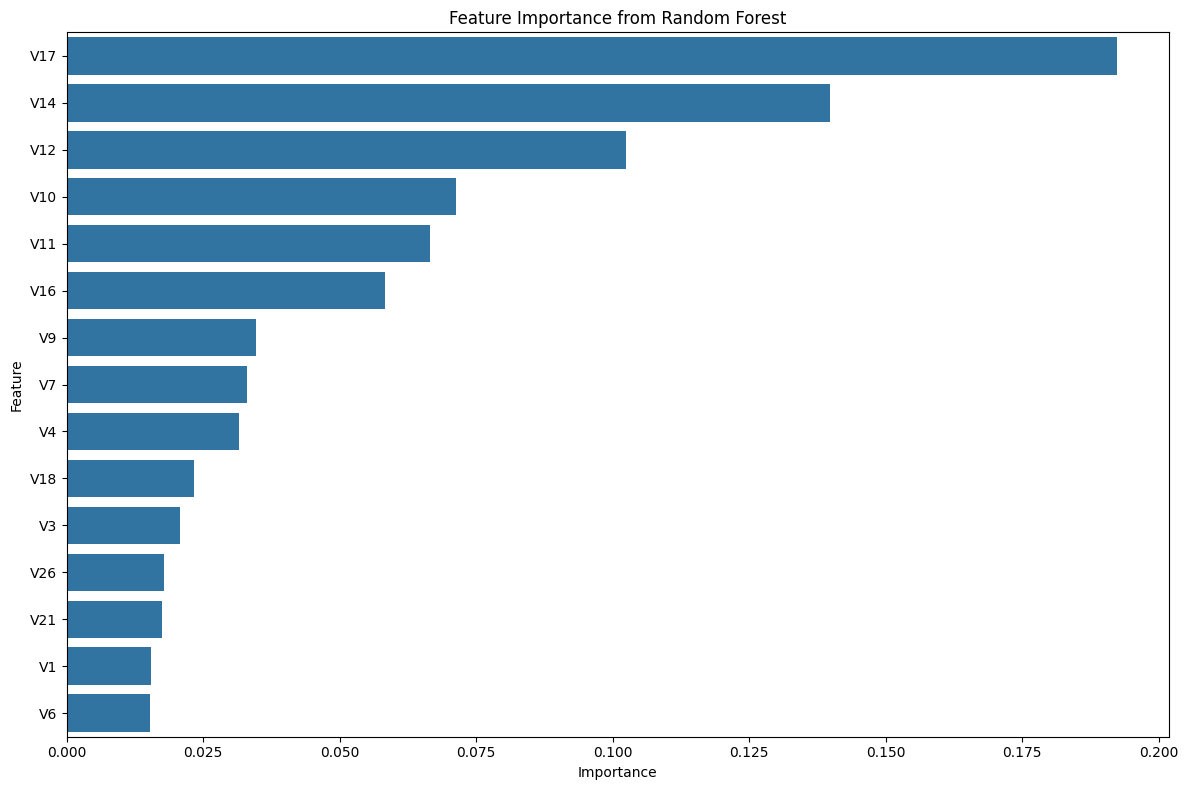

Top 15 important features:
   Feature  Importance
16     V17    0.192278
13     V14    0.139783
11     V12    0.102377
9      V10    0.071407
10     V11    0.066568
15     V16    0.058255
8       V9    0.034783
6       V7    0.033137
3       V4    0.031502
17     V18    0.023424
2       V3    0.020696
25     V26    0.017845
20     V21    0.017430
0       V1    0.015420
5       V6    0.015306


In [14]:
# Section 5: Supervised Learning Models for Fraud Detection
# 5.1 Logistic Regression
start_time = time.time()
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Results:")
print(f"Training time: {time.time() - start_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix for Logistic Regression
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Precision-Recall Curve for Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
pr_auc_lr = average_precision_score(y_test, y_prob_lr)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(recall_lr, precision_lr, color='blue', lw=2, label=f'PR curve (area = {pr_auc_lr:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# 5.2 Random Forest
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print(f"Training time: {time.time() - start_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Precision-Recall Curve for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
pr_auc_rf = average_precision_score(y_test, y_prob_rf)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(recall_rf, precision_rf, color='blue', lw=2, label=f'PR curve (area = {pr_auc_rf:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# 5.3 Feature Importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

print("Top 15 important features:")
print(feature_importance.head(15))

Original class distribution in training set:
Class
0    227451
1       394
Name: count, dtype: int64

Class distribution after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64

Random Forest with SMOTE Results:
Training time: 463.28 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.81      0.81        98

    accuracy                           1.00     56962
   macro avg       0.91      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



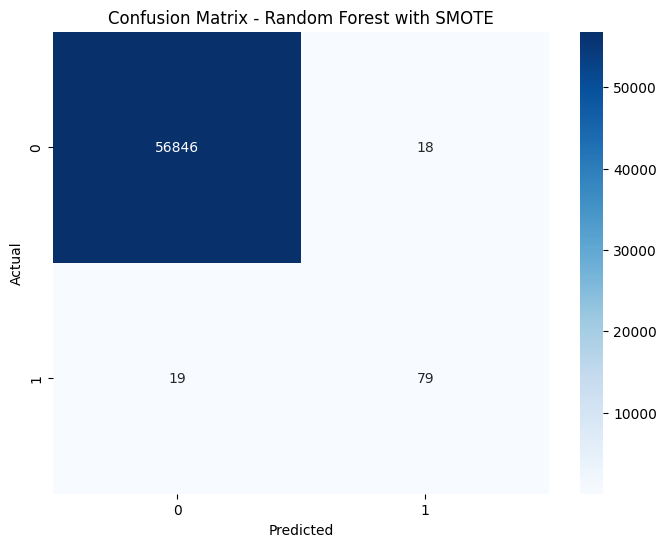

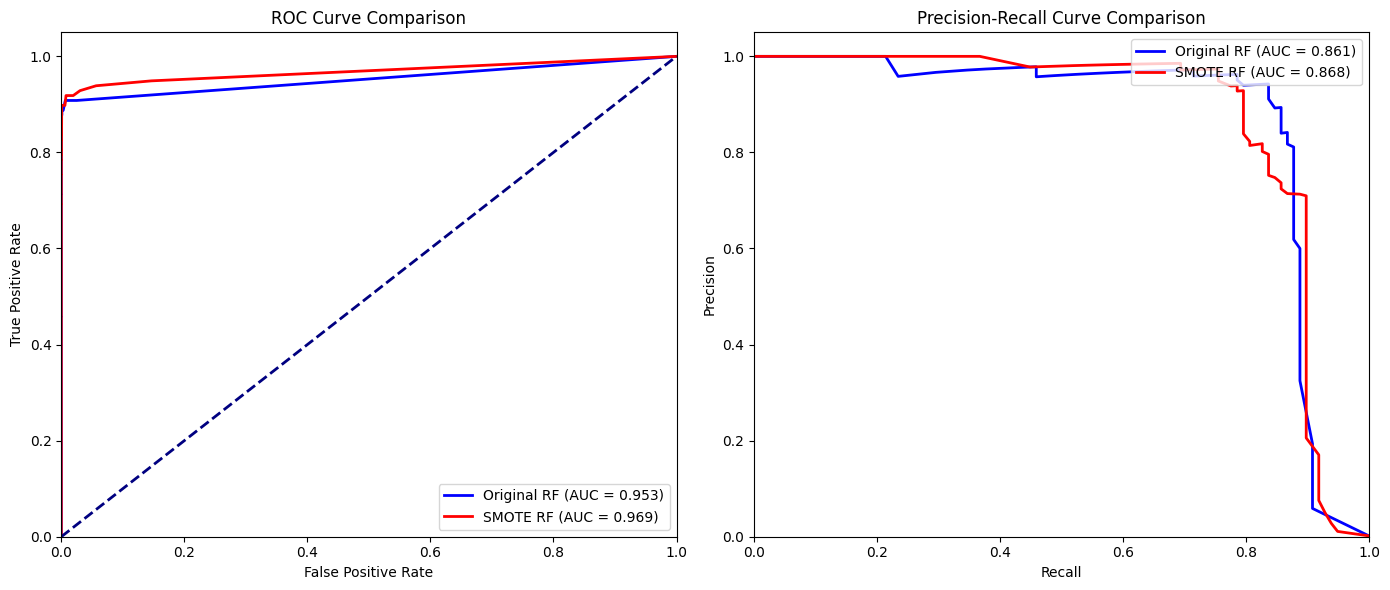

In [17]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
# Section 6: Handling Class Imbalance with SMOTE
print("Original class distribution in training set:")
print(pd.Series(y_train).value_counts())

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Train a Random Forest model with SMOTE-resampled data
start_time = time.time()
rf_smote_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote_model.fit(X_train_smote, y_train_smote)

y_pred_rf_smote = rf_smote_model.predict(X_test)
y_prob_rf_smote = rf_smote_model.predict_proba(X_test)[:, 1]

print("\nRandom Forest with SMOTE Results:")
print(f"Training time: {time.time() - start_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_smote))

# Confusion Matrix for Random Forest with SMOTE
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf_smote)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest with SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compare ROC curves between original and SMOTE-resampled models
fpr_rf_smote, tpr_rf_smote, _ = roc_curve(y_test, y_prob_rf_smote)
roc_auc_rf_smote = auc(fpr_rf_smote, tpr_rf_smote)

# Compare Precision-Recall curves
precision_rf_smote, recall_rf_smote, _ = precision_recall_curve(y_test, y_prob_rf_smote)
pr_auc_rf_smote = average_precision_score(y_test, y_prob_rf_smote)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Original RF (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_rf_smote, tpr_rf_smote, color='red', lw=2, label=f'SMOTE RF (AUC = {roc_auc_rf_smote:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(recall_rf, precision_rf, color='blue', lw=2, label=f'Original RF (AUC = {pr_auc_rf:.3f})')
plt.plot(recall_rf_smote, precision_rf_smote, color='red', lw=2, label=f'SMOTE RF (AUC = {pr_auc_rf_smote:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

Shape of legitimate transactions for unsupervised learning: (227451, 30)
Isolation Forest Results:
Training time: 1.55 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.08      0.54      0.14        98

    accuracy                           0.99     56962
   macro avg       0.54      0.77      0.57     56962
weighted avg       1.00      0.99      0.99     56962



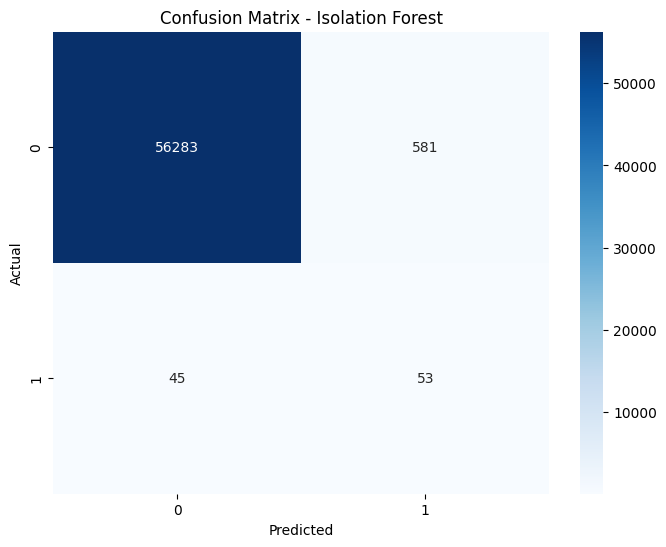

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Local Outlier Factor Results:
Training time: 308.81 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.02      0.12      0.04        98

    accuracy                           0.99     56962
   macro avg       0.51      0.56      0.52     56962
weighted avg       1.00      0.99      0.99     56962



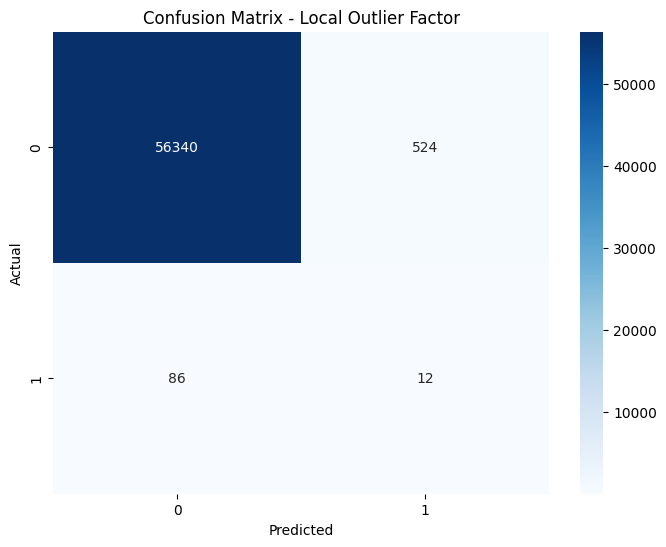

One-Class SVM Results:
Training time: 0.89 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.89      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.92      0.51     56962
weighted avg       1.00      0.94      0.97     56962



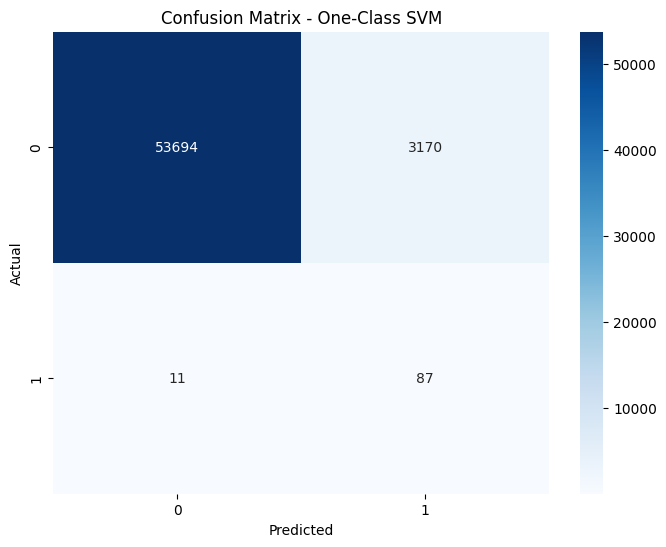

In [20]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
# Section 7: Unsupervised Anomaly Detection Techniques
# Extract only the legitimate transactions for training unsupervised models
X_legitimate = X_train[y_train == 0]
print("Shape of legitimate transactions for unsupervised learning:", X_legitimate.shape)

# 7.1 Isolation Forest
start_time = time.time()
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
isolation_forest.fit(X_legitimate)

# Predict anomalies on the test set
y_pred_if = isolation_forest.predict(X_test)
# Convert predictions: 1 is inlier (normal), -1 is outlier (fraud)
# We need to convert to match our labels: 0 for normal, 1 for fraud
y_pred_if = (y_pred_if == -1).astype(int)

print("Isolation Forest Results:")
print(f"Training time: {time.time() - start_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_if))

# Confusion Matrix for Isolation Forest
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_if)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7.2 Local Outlier Factor
start_time = time.time()
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
lof.fit(X_legitimate)

# Predict anomalies on the test set
y_pred_lof = lof.predict(X_test)
# Convert predictions: 1 is inlier (normal), -1 is outlier (fraud)
y_pred_lof = (y_pred_lof == -1).astype(int)

print("Local Outlier Factor Results:")
print(f"Training time: {time.time() - start_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lof))

# Confusion Matrix for Local Outlier Factor
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_lof)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Local Outlier Factor')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7.3 One-Class SVM
# Note: One-Class SVM can be computationally expensive for large datasets
# Use a smaller subset for demonstration
subset_size = min(5000, len(X_legitimate))
X_legitimate_subset = X_legitimate.sample(subset_size, random_state=42)

start_time = time.time()
ocsvm = OneClassSVM(gamma='auto', nu=0.01)
ocsvm.fit(X_legitimate_subset)

# Predict anomalies on the test set
y_pred_ocsvm = ocsvm.predict(X_test)
# Convert predictions: 1 is inlier (normal), -1 is outlier (fraud)
y_pred_ocsvm = (y_pred_ocsvm == -1).astype(int)

print("One-Class SVM Results:")
print(f"Training time: {time.time() - start_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ocsvm))

# Confusion Matrix for One-Class SVM
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_ocsvm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - One-Class SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Model Comparison:
                  Model  Accuracy  Precision (Fraud)  Recall (Fraud)  \
0   Logistic Regression  0.999157           0.828947        0.642857   
1         Random Forest  0.999596           0.941176        0.816327   
2         RF with SMOTE  0.999350           0.814433        0.806122   
3      Isolation Forest  0.989010           0.083596        0.540816   
4  Local Outlier Factor  0.989291           0.022388        0.122449   
5         One-Class SVM  0.944156           0.026712        0.887755   

   F1-Score (Fraud)  
0          0.724138  
1          0.874317  
2          0.810256  
3          0.144809  
4          0.037855  
5          0.051863  


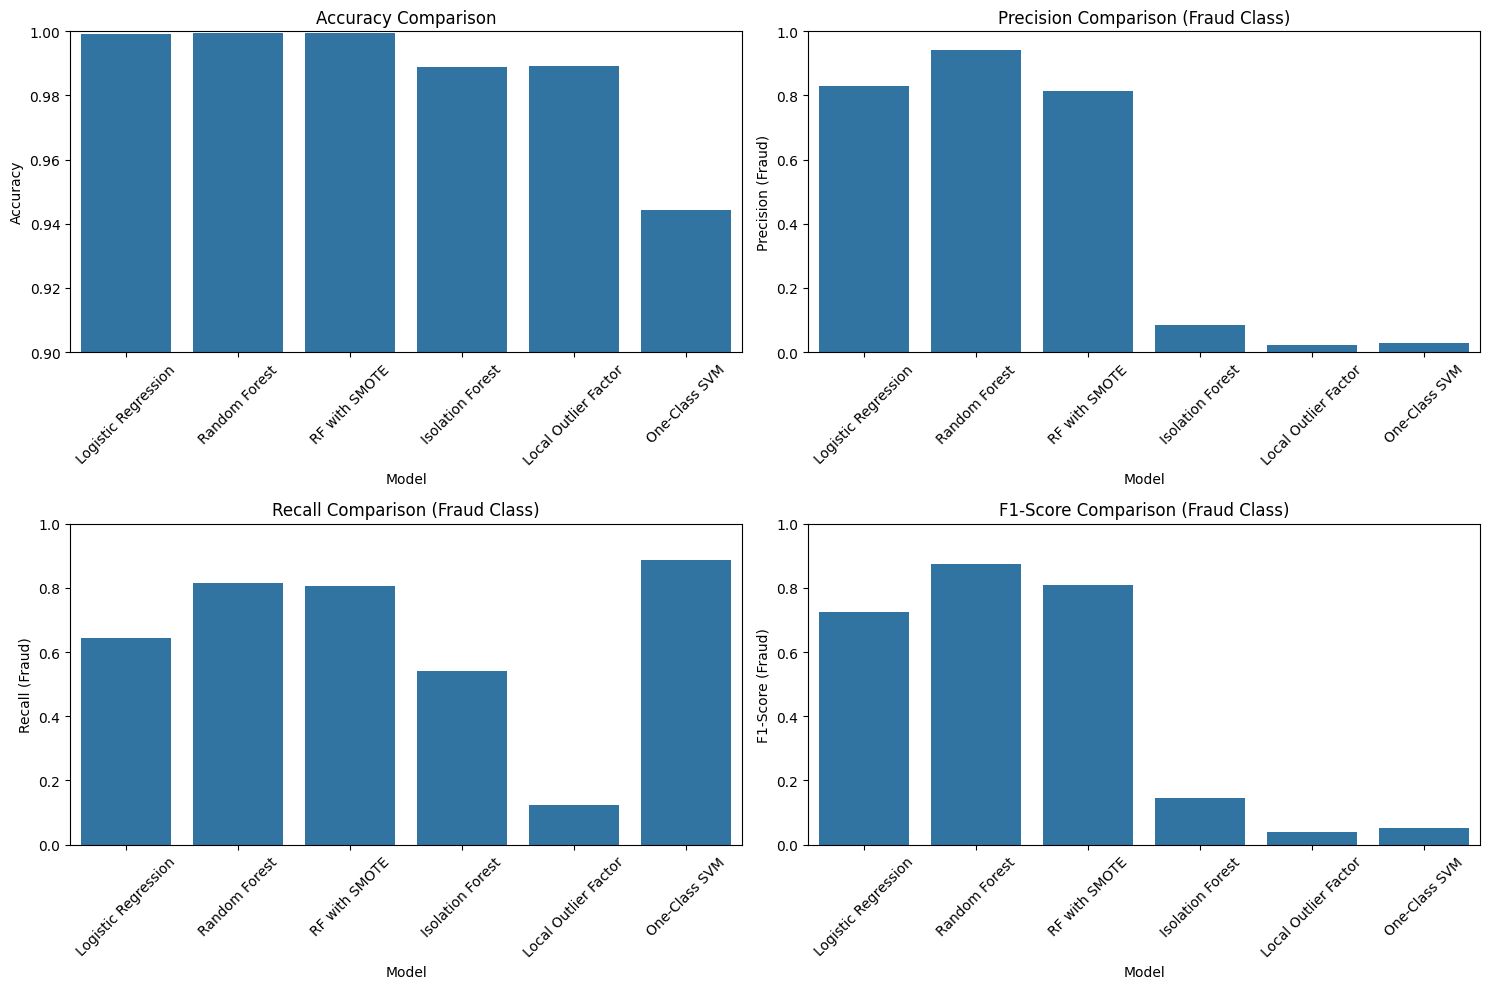

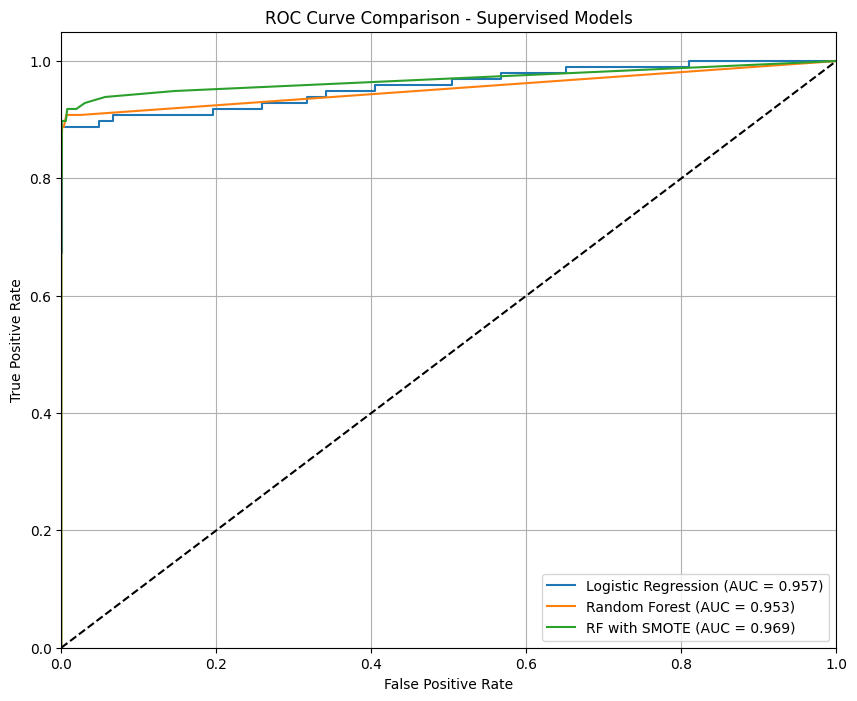

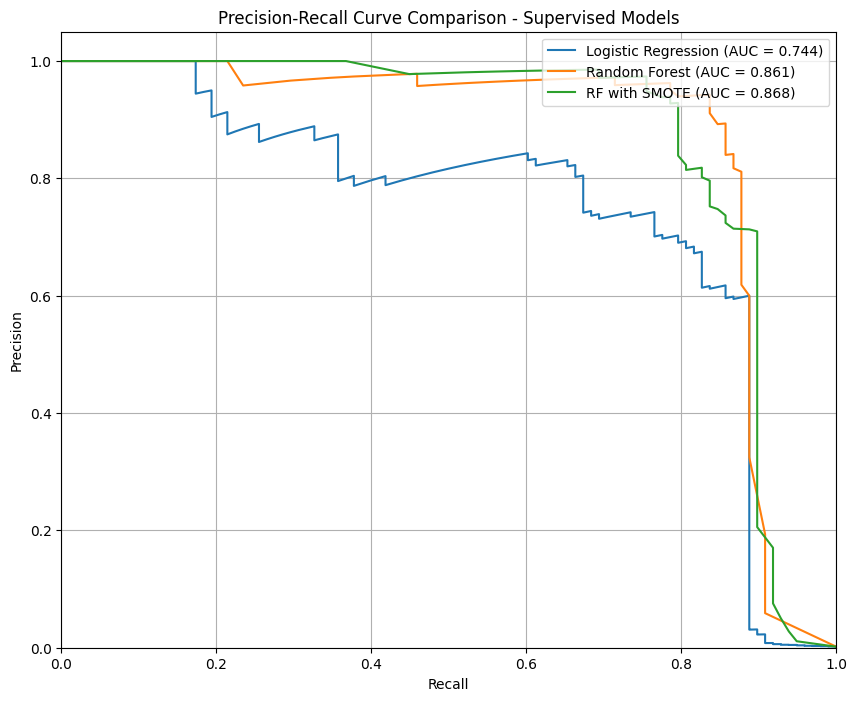

In [21]:
# Section 8: Model Comparison and Evaluation
# Collect all evaluation metrics
models = ['Logistic Regression', 'Random Forest', 'RF with SMOTE', 'Isolation Forest', 'Local Outlier Factor', 'One-Class SVM']
y_preds = [y_pred_lr, y_pred_rf, y_pred_rf_smote, y_pred_if, y_pred_lof, y_pred_ocsvm]
y_probs = [y_prob_lr, y_prob_rf, y_prob_rf_smote, None, None, None]  # Unsupervised methods don't have probabilities

# Calculate metrics
metrics = []
for i, model in enumerate(models):
    report = classification_report(y_test, y_preds[i], output_dict=True)
    metrics.append({
        'Model': model,
        'Accuracy': report['accuracy'],
        'Precision (Fraud)': report['1']['precision'],
        'Recall (Fraud)': report['1']['recall'],
        'F1-Score (Fraud)': report['1']['f1-score']
    })

metrics_df = pd.DataFrame(metrics)
print("Model Comparison:")
print(metrics_df)

# Plot comparison of models using bar charts
plt.figure(figsize=(15, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=metrics_df)
plt.title('Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0.9, 1.0)  # Adjust as needed based on your results

# Plot precision
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision (Fraud)', data=metrics_df)
plt.title('Precision Comparison (Fraud Class)')
plt.xticks(rotation=45)
plt.ylim(0, 1.0)

# Plot recall
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Recall (Fraud)', data=metrics_df)
plt.title('Recall Comparison (Fraud Class)')
plt.xticks(rotation=45)
plt.ylim(0, 1.0)

# Plot F1-Score
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='F1-Score (Fraud)', data=metrics_df)
plt.title('F1-Score Comparison (Fraud Class)')
plt.xticks(rotation=45)
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

# Compare ROC curves for supervised models
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_rf_smote, tpr_rf_smote, label=f'RF with SMOTE (AUC = {roc_auc_rf_smote:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Supervised Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Compare Precision-Recall curves for supervised models
plt.figure(figsize=(10, 8))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC = {pr_auc_lr:.3f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {pr_auc_rf:.3f})')
plt.plot(recall_rf_smote, precision_rf_smote, label=f'RF with SMOTE (AUC = {pr_auc_rf_smote:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison - Supervised Models')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

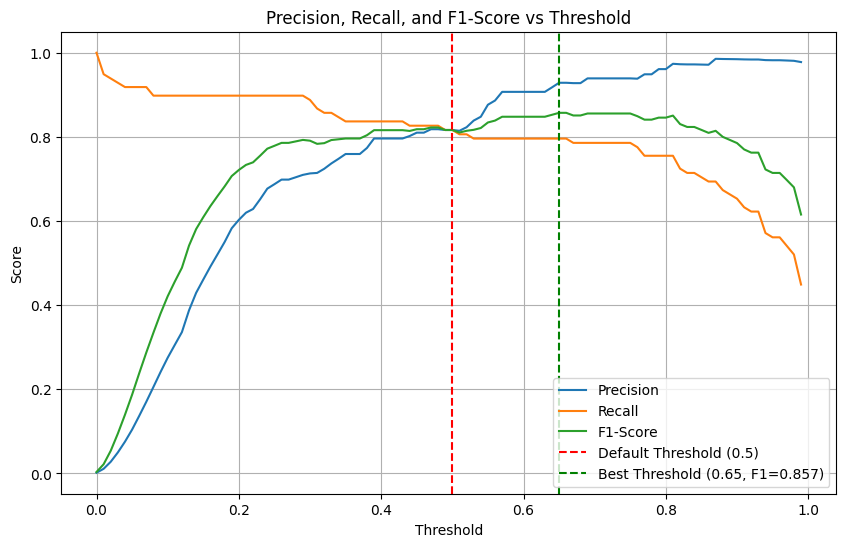

Best threshold: 0.6500 with F1-Score: 0.8571

Final Model Performance (RF with SMOTE, tuned threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.80      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



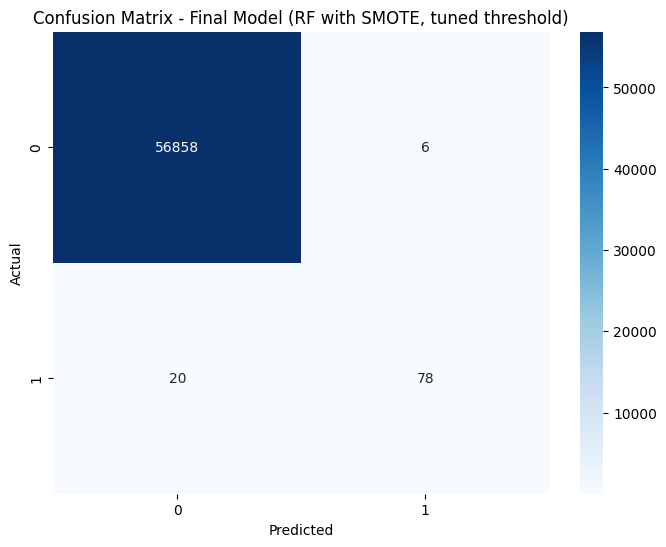

In [22]:
# Section 9: Threshold Tuning for Best Model
# Use the best performing model (Random Forest with SMOTE) to find optimal threshold
thresholds = np.arange(0, 1, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred_tuned = (y_prob_rf_smote >= threshold).astype(int)
    precision = classification_report(y_test, y_pred_tuned, output_dict=True)['1']['precision']
    recall = classification_report(y_test, y_pred_tuned, output_dict=True)['1']['recall']
    f1 = classification_report(y_test, y_pred_tuned, output_dict=True)['1']['f1-score']
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot precision, recall, and F1-score vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.axvline(x=0.5, color='r', linestyle='--', label='Default Threshold (0.5)')

# Find best F1-score and corresponding threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
plt.axvline(x=best_threshold, color='g', linestyle='--',
            label=f'Best Threshold ({best_threshold:.2f}, F1={best_f1:.3f})')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best threshold: {best_threshold:.4f} with F1-Score: {best_f1:.4f}")

# Apply the best threshold to get final predictions
y_pred_final = (y_prob_rf_smote >= best_threshold).astype(int)
print("\nFinal Model Performance (RF with SMOTE, tuned threshold):")
print(classification_report(y_test, y_pred_final))

# Final confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Final Model (RF with SMOTE, tuned threshold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Cost Analysis:
                   Model  Total Cost  False Positive Cost  False Negative Cost
0    Logistic Regression        3630                  130                 3500
1          Random Forest        1850                   50                 1800
2          RF with SMOTE        2080                  180                 1900
3  RF with SMOTE (Tuned)        2060                   60                 2000


<Figure size 1200x600 with 0 Axes>

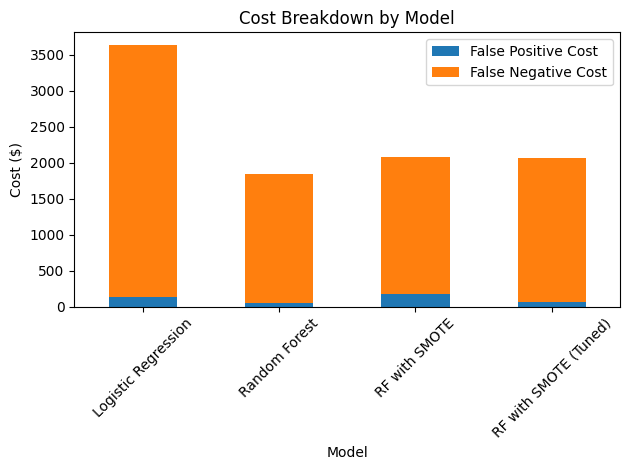

In [23]:
# Section 10: Cost Analysis (assuming costs associated with false positives and false negatives)
# Assuming:
# - False Negative Cost (missing fraud): $100 per transaction
# - False Positive Cost (false alarm): $10 per transaction

def calculate_cost(y_true, y_pred, fn_cost=100, fp_cost=10):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = (fp * fp_cost) + (fn * fn_cost)
    return total_cost, fp * fp_cost, fn * fn_cost

# Calculate costs for different models
cost_data = []
for i, model in enumerate(models[:3]):  # Only using supervised models
    total_cost, fp_cost, fn_cost = calculate_cost(y_test, y_preds[i])
    cost_data.append({
        'Model': model,
        'Total Cost': total_cost,
        'False Positive Cost': fp_cost,
        'False Negative Cost': fn_cost
    })

# Add tuned model
total_cost_tuned, fp_cost_tuned, fn_cost_tuned = calculate_cost(y_test, y_pred_final)
cost_data.append({
    'Model': 'RF with SMOTE (Tuned)',
    'Total Cost': total_cost_tuned,
    'False Positive Cost': fp_cost_tuned,
    'False Negative Cost': fn_cost_tuned
})

cost_df = pd.DataFrame(cost_data)
print("Cost Analysis:")
print(cost_df)

# Visualize costs
plt.figure(figsize=(12, 6))
models_for_plot = cost_df['Model']
costs = cost_df[['False Positive Cost', 'False Negative Cost']]
costs.index = models_for_plot
costs.plot(kind='bar', stacked=True)
plt.title('Cost Breakdown by Model')
plt.ylabel('Cost ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
# Section 11: Model Deployment Preparation
# Save the best model
import joblib
import pandas as pd
import numpy as np

# Save the SMOTE Random Forest model
joblib.dump(rf_smote_model, 'fraud_detection_model.pkl')
print("Model saved as 'fraud_detection_model.pkl'")

# Save the scaler
joblib.dump(scaler, 'fraud_detection_scaler.pkl')
print("Scaler saved as 'fraud_detection_scaler.pkl'")

# Create a function for making predictions with the saved model
def predict_fraud(transaction_data, model_path='fraud_detection_model.pkl', scaler_path='fraud_detection_scaler.pkl', threshold=best_threshold):
    """
    Predict if a transaction is fraudulent

    Parameters:
    transaction_data (pd.DataFrame): Transaction data with required features
    model_path (str): Path to the saved model
    scaler_path (str): Path to the saved scaler
    threshold (float): Classification threshold

    Returns:
    dict: Prediction results
    """
    try:
        # Load model and scaler
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)

        # Prepare the data
        if 'Time' in transaction_data and 'Amount' in transaction_data:
            # Feature engineering: Extract hour from Time (assuming Time is in seconds)
            transaction_data['Hour'] = (transaction_data['Time'] % (24 * 3600)) // 3600

            # Scale the 'Amount' column (assuming this matches your training preprocessing)
            transaction_data['Amount_Scaled'] = scaler.transform(transaction_data[['Amount']])

            # Drop unnecessary columns (e.g., Time, Amount) after feature engineering
            features = transaction_data.drop(columns=['Time', 'Amount'], errors='ignore')
        else:
            raise ValueError("Required columns 'Time' and 'Amount' are missing in the transaction data.")

        # Ensure all expected features are present (e.g., V1-V28, Hour, Amount_Scaled)
        expected_features = [f'V{i}' for i in range(1, 29)] + ['Hour', 'Amount_Scaled']
        missing_features = [col for col in expected_features if col not in features.columns]
        if missing_features:
            raise ValueError(f"Missing features in transaction data: {missing_features}")

        # Reorder features to match the training data
        features = features[expected_features]

        # Make predictions (probability of fraud)
        fraud_probabilities = model.predict_proba(features)[:, 1]  # Probability of class 1 (fraud)

        # Apply threshold to get binary predictions
        predictions = (fraud_probabilities >= threshold).astype(int)

        # Prepare the results
        results = {
            'predictions': predictions.tolist(),  # Binary predictions (0 or 1)
            'fraud_probabilities': fraud_probabilities.tolist(),  # Probabilities of fraud
            'threshold': threshold  # Threshold used
        }

        return results

    except Exception as e:
        return {'error': str(e)}


Model saved as 'fraud_detection_model.pkl'
Scaler saved as 'fraud_detection_scaler.pkl'
